In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

#Cuda 혹은 cpu를 사용하시오.
############Write Your Code Here############
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
############################################


#Custom_Dataset을 정의하시오.(10점)
class Custom_Dataset(Dataset):
    def __init__(self, X, y):
        #입력으로 들어온 X의 pixel값들을 0-1사이로 normalize하고 X의 shape을 (FB,C,H,W)로 변경하여 저장하여 self.X,self.y에 저장하시오.
        self.X = None
        self.y = None
        ############Write Your Code Here############
        self.X = X.reshape(-1,3,32,32) / 255.0
        #self.X = X / 255.0
        self.y = y
        ############################################
        
    def __len__(self):
        #Custom_Dataset에 저장되어있는 총 data의 개수를 result에 저장하여 반환하시오.
        result = 0
        ############Write Your Code Here############
        result = len(self.X)
        ############################################
        return result
    
    def __getitem__(self, idx):
        #self.X, self.y 에서 idx에 맞는 data를 result_X,result_y에 저장하여 반환하시오.
        result_X,result_y = None,None
        ############Write Your Code Here############
        result_X = self.X[idx]
        result_y = self.y[idx]
        ############################################
        return result_X,result_y

    
#torch.nn을 사용하여 아래 함수들을 작성하시오. result는 nn.Layer중 하나이고 result를 반환함.(20점)
def batch_norm(dim,for_MLP=True):
    #for_MLP가 True일 시 MLP를 위한 BN Layer를 반환하고 False일 시 CNN을 위한 BN Layer를 반환함.
    ############Write Your Code Here############
    result = None
    if for_MLP == True :
        result = nn.BatchNorm1d(dim)
    else :
        result = nn.BatchNorm2d(dim)
    ############################################
    return result

def fc_layer(in_dim,out_dim):
    #Fully Connected Layer(Dense Layer)
    ############Write Your Code Here############
    result = nn.Linear(in_dim,out_dim)
    ############################################
    return result

def conv_layer(in_ch,out_ch,kernel_size, stride=1, padding=0):
    #Convolutional Layer for image
    ############Write Your Code Here############
    result = nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding)
    ############################################
    return result

def relu():
    #ReLU function
    ############Write Your Code Here############
    result = nn.ReLU()
    ############################################
    return result

def flatten():
    #Flatten the data
    ############Write Your Code Here############
    result = nn.Flatten()
    ############################################
    return result


#skip_connection(bn -> relu -> conv -> bn -> relu -> conv)를 따르는 Res_block을 만드시오.
#change_res가 True인 res_block을 통과한 feature map은 resolution이 2배 작아지고 channel의 깊이는 2배로 증가함. ex) 32*8*8 -> 64*4*4
#위의 경우에는 skip_connection의 dimension은 1*1 conv로 맞춰줌.
#change_res가 False인 Res_block을 통과한 feature map은 resolution과 channel의 깊이는 그대로 유지됨. ex) 32*4*4 -> 32*4*4(20점)
class Res_block(nn.Module):
    def __init__(self, input_channel, change_res):
        super(Res_block,self).__init__()
        self.change_res = change_res
        if change_res:
            ############Write Your Code Here############
            self.residual_block = nn.Sequential(
                conv_layer(input_channel,input_channel*2,(3,3), stride=2, padding=1),
                batch_norm(input_channel*2,for_MLP=False),
                relu(),
                conv_layer(input_channel*2,input_channel*2,(3,3), stride=1, padding=1),
                batch_norm(input_channel*2,for_MLP=False)
            )
            ############################################
        else:
            ############Write Your Code Here############
            self.residual_block = nn.Sequential(
                conv_layer(input_channel,input_channel,(3,3), stride=1, padding=1),
                batch_norm(input_channel,for_MLP=False),
                relu(),
                conv_layer(input_channel,input_channel,(3,3), stride=1, padding=1),
                batch_norm(input_channel,for_MLP=False)
            )
            ############################################
        ############Write Your Code Here############
        self.relu = relu()
        self.short_cut = nn.Sequential(
            conv_layer(input_channel,input_channel*2,(1,1), stride=2),
            batch_norm(input_channel*2,for_MLP=False)
        )
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        if self.change_res :
            X = self.short_cut(X) + self.residual_block(X)
        else :
            X = X + self.residual_block(X)
        X = self.relu(X)
        ############################################
        return X

    
#Skip Connection을 이용하여 20개 이상의 layer를 가지고 테스트 셋에대하여 50% 이상의 성능을 주는 MLP를 만드시오.
#nn.ModuleList를 사용하면 많을 층의 layer를 쌓는데 용이함.(20점)
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP,self).__init__()
        ############Write Your Code Here############
        self.flatten = nn.Flatten(start_dim=1)
        self.layers1 = nn.ModuleList()
        for i in range(3) :
            self.layers1.append(nn.Sequential(
                fc_layer(input_dim,input_dim),
                relu(),
                fc_layer(input_dim,input_dim),
                relu()
            ))
        
        self.hidden_dim1 = max(input_dim//2,output_dim)
        self.hidden_layer1 = nn.Sequential(
            fc_layer(input_dim,self.hidden_dim1),
            relu()
        )
        self.layers2 = nn.ModuleList()
        for i in range(3,6) :
            self.layers2.append(nn.Sequential(
                fc_layer(self.hidden_dim1,self.hidden_dim1),
                relu(),
                fc_layer(self.hidden_dim1,self.hidden_dim1),
                relu()
            ))
        
        self.hidden_dim2 = max(self.hidden_dim1//2,output_dim)
        self.hidden_layer2 = nn.Sequential(
            fc_layer(self.hidden_dim1,self.hidden_dim2),
            relu()
        )
        self.layers3 = nn.ModuleList()
        for i in range(6,9) :
            self.layers3.append(nn.Sequential(
                fc_layer(self.hidden_dim2,self.hidden_dim2),
                relu(),
                fc_layer(self.hidden_dim2,self.hidden_dim2),
                relu()
            ))

        self.output_layer = nn.Sequential(
            fc_layer(self.hidden_dim2,output_dim),
            nn.Softmax(dim = 1)
        )
        self.relu = relu()
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        X = self.flatten(X)
        for layer in self.layers1 :
            X = X + layer(X)
            X = self.relu(X)
        X = self.hidden_layer1(X)
        for layer in self.layers2 :
            X = X + layer(X)
            X = self.relu(X)
        X = self.hidden_layer2(X)
        for layer in self.layers3 :
            X = X + layer(X)
            X = self.relu(X)
        X = self.output_layer(X)
        ############################################
        return X
        
#Res_Block을 사용하여 테스트 셋에대한 70% 이상의 성능을 주는 CNN 모델을 만드시오.
#flatten전에 nn.AdaptiveAvgPool2d를 사용하면 dimension맞추기가 쉬움.(20점)
class CNN(nn.Module):
    def __init__(self, input_channel, class_number, block_number):
        super(CNN,self).__init__()
        ############Write Your Code Here############
        self.in_planes = 64
        self.conv1 = conv_layer(3, 64, 3, 1, 1)
        self.bn1 = batch_norm(64,for_MLP=False)

        def make_RES_layer(planes, block_number, stride):
            strides = [stride] + [1]*(block_number-1)
            layers = []
            for stride in strides:
                if stride == 1 :
                    layers.append(Res_block(self.in_planes, change_res = False))
                else :
                    layers.append(Res_block(self.in_planes, change_res = True))
                    self.in_planes = planes * 2
            return nn.Sequential(*layers)

        self.layer1 = make_RES_layer(64,block_number[0],stride = 2)
        self.layer2 = make_RES_layer(128,block_number[1],stride = 2)
        self.layer3 = make_RES_layer(256,block_number[2],stride = 2)
        self.layer4 = make_RES_layer(512,block_number[3],stride = 2)
        self.linear = fc_layer(512 *2,class_number)


        self.relu = relu()
        ############################################
    def forward(self,X):
        ############Write Your Code Here############
        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)
        X = self.layer4(X)
        X = nn.functional.avg_pool2d(X,2)
        X = X.view(X.size(0),-1)
        X = self.linear(X)
        ############################################
        return X

#loader에 있는 모든 data들에 대한 정확도를 구하여 accuracy에 저장하여 accuracy를 return하는 함수를 구현하시오.(10점)
def evaluate(model, loader):
    model.eval()
    accuracy = 0
    total_example = 0
    correct_example = 0
    for data in loader:
        x,y = data
        x = torch.tensor(x, device = device)
        y = torch.tensor(y, device = device)
        ############Write Your Code Here############
        outputs = model(x.float())
        _, predict = torch.max(outputs.data,1)
        total_example += y.size(0)
        correct_example += (predict == y).sum().item()
        ############################################
    ############Write Your Code Here############
    accuracy = 100 * correct_example / total_example
    ############################################
    model.train()
    return accuracy

#epoch마다 train_loader에 있는 batch들을 사용하여 모델을 학습하고
#epoch의 마지막 iteration에서는 모델의 validation accuracy를 확인하여 제일 높은 val. acc.를 가진 model을 best_model에 저장하고
#val_acc에는 매 epoch마다 구해진 validation accuracy를 저장하시오.
#running_loss에는 각각의 epoch에서 모든 batch의 loss를 다 더하여 저장하시오.
#모든 epoch의 validation accuracy를 val_acc에 저장하여 best_model과 val_acc를 return하는 함수를 구현하시오.(10점)
def train(model, epoches, train_loader, val_loader, optimizer, criteria):
    best_score = 0
    best_model = None
    batch_len = len(train_loader)
    val_acc = []
    for epoch in range(epoches):
        running_loss = 0
        for i,data in enumerate(train_loader):
            x,y = data
            x = torch.tensor(x, device = device)
            y = torch.tensor(y, device = device)
            ############Write Your Code Here############
            optimizer.zero_grad()
            outputs = model(x.float())
            loss = criteria(outputs,y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ############################################
            
            #epoch의 마지막 iteration
            if i % batch_len == batch_len-1:
                print(f'{epoch+1}th iteration loss :',running_loss/batch_len)
                running_loss = 0
                ############Write Your Code Here############
                score = evaluate(model,val_loader)
                print(f'{epoch+1}th validation accuracy :',score)
                val_acc.append(score)
                if score > best_score :
                    best_score = score
                    best_model = deepcopy(model)
                ############################################
    return best_model, val_acc

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:255: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

MLP accuracy: 50.49
CNN accuracy: 83.13


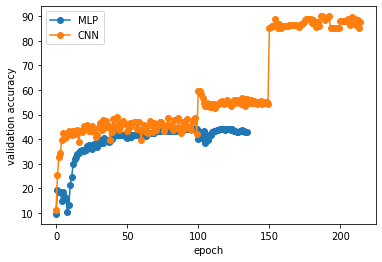

In [ ]:
#(50점)
#Read the data
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True)

X_train, Y_train = trainset.data, np.array(trainset.targets)
X_test, Y_test = testset.data, np.array(testset.targets)


#앞서 정의한 Custom_Dataset과 DataLoader를 사용하여 train_loader,val_loader,test_loader를 정의하시오.
#Batch_size는 본인의 컴퓨터 사향에 맞게 변경하면 됨. Validation Set으로 Train Set의 20%를 사용함.
#Preprocessing
train_loader = None
val_loader = None
test_loader = None
batch_size = 1
############Write Your Code Here############
from torch.utils.data.dataset import random_split
batch_size = 32
dataset = Custom_Dataset(X_train,Y_train)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, valset = random_split(dataset,[train_size,test_size])
train_loader = DataLoader(dataset = trainset, batch_size = batch_size)
val_loader = DataLoader(dataset = valset, batch_size = batch_size)

dataset2 = Custom_Dataset(X_test,Y_test)
test_loader = DataLoader(dataset = dataset2, batch_size = batch_size)
############################################


#앞서 정의한 MLP,CNN을 사용하여 mlp_model,cnn_model을 정의하시오.
#Define the model
mlp_model = None
cnn_model = None
############Write Your Code Here############
import torch.nn.init as init
def _weights_init(net): # Weight 초기화 함수
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)

mlp_model = MLP(32*32*3,10).float()
mlp_model.apply(_weights_init)
cnn_model = CNN(3,10,[2,2,2,2]).float()
cnn_model.apply(_weights_init)
############################################
mlp_model.to(device)
cnn_model.to(device)


#앞서 정의한 train함수를 사용하여 best_mlp, mpl_val_acc, best_cnn, cnn_val_acc를 구하시오.
#Train the model
best_mlp = None
mlp_val_acc = None
best_cnn = None
cnn_val_acc = None
############Write Your Code Here############

# 학습 진행중 끊기는 일이 잦아 (교수님께서 가능하다고 답변을 주셔서) model save, load를 구현하였습니다. 
# 용량 관계로 checkpoint model은 따로 첨부하지 않았습니다.
# 만약 체점에 필요하시다면 Google Drive를 통해 공유하도록 하겠습니다!

import torch.optim as optim
import os


mlp_checkpoint = True # Checkpoint Load
start_epoch = 0
best_acc = 0
mlp_val_acc = []
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.5, patience = 0, verbose = True)

if mlp_checkpoint :
    checkpoint = torch.load('./checkpoint/mlp_checkpoint.pth')
    mlp_model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['best_acc']
    mlp_val_acc = checkpoint['val_acc']
    start_epoch = checkpoint['epoch']
    best_mlp = mlp_model



mlp_model.to(device)

for epoch in range(start_epoch,130,5) : # 학습이 더 진행되지 않도록 일부러 range를 종료 시점의 epoch로 변경해 놓았습니다
    print(f"<< Epoch :: {epoch} >>")
    best_mlp, temp_val_acc = train(mlp_model, 5, train_loader, val_loader, optimizer, criteria)
    mlp_val_acc.append(temp_val_acc)
    mlp_acc = evaluate(best_mlp,val_loader)
    print(f'{epoch} MLP accuracy:',mlp_acc)
    
    if mlp_acc > best_acc: # Checkpoint Save
        print('Saving..')
        state = {
            'model': best_mlp.state_dict(),
            'best_acc': best_acc,
            'val_acc': mlp_val_acc,
            'epoch': epoch+5,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/mlp_checkpoint.pth')
        best_acc = mlp_acc

    scheduler.step(mlp_acc)
    print("last lr : ", scheduler._last_lr)
    print("optimizer lr : ", optimizer.param_groups[0]['lr'])







cnn_checkpoint = True # Checkpoint Load
start_epoch = 0
best_acc = 0
cnn_val_acc = []
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', factor = 0.5, patience = 3, verbose = True)

if cnn_checkpoint :
    checkpoint = torch.load('./checkpoint/cnn_checkpoint.pth')
    cnn_model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['best_acc']
    cnn_val_acc = checkpoint['val_acc']
    start_epoch = checkpoint['epoch']
    best_cnn = cnn_model


cnn_model.to(device)
for epoch in range(start_epoch,215,5) : # 학습이 더 진행되지 않도록 일부러 range를 종료 시점의 epoch로 변경해 놓았습니다
    print(f"<< Epoch :: {epoch} >>")
    best_cnn, temp_val_acc = train(cnn_model, 5, train_loader, val_loader, optimizer, criteria)
    cnn_val_acc.append(temp_val_acc)
    cnn_acc = evaluate(best_cnn,val_loader)
    print(f'{epoch} CNN accuracy:',cnn_acc)
    
    if cnn_acc > best_acc: # Checkpoint Save
        print('Saving..')
        state = {
            'model': best_cnn.state_dict(),
            'best_acc': best_acc,
            'val_acc': cnn_val_acc,
            'epoch': epoch+5,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/cnn_checkpoint.pth')
        best_acc = cnn_acc

    scheduler.step(cnn_acc)
    print("last lr : ", scheduler._last_lr)
    print("optimizer lr : ", optimizer.param_groups[0]['lr'])

############################################


#앞서 정의한 evaluate함수와 best_model들을 사용하여 mlp_acc, cnn_acc를 구하시오.
#Test Accuracy
mlp_acc = None  
cnn_acc = None 
############Write Your Code Here############
mlp_acc = evaluate(best_mlp,test_loader)
cnn_acc = evaluate(best_cnn,test_loader)
############################################
print('MLP accuracy:',mlp_acc)
print('CNN accuracy:',cnn_acc)


#앞서 구한 val_acc들을 사용하여 이해 가능한 그래프를 그리시오.
#Validation Accuracy Plot
############Write Your Code Here############
plt.plot(sum(mlp_val_acc, []), marker='o', label = "MLP")
plt.plot(sum(cnn_val_acc, []), marker='o', label = "CNN")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.show()
############################################